In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Low Rank Approximation (PCA)

- Many data sets come in the form of a matrix.
- Think of $A$ as a stack of $n$ data points in $\mathbb{R}^d$.
- For example, $A$ can be a customer-product matrix, where each entry $A_{ij}$ refers to the number of times customer $i$ purchased item $j$.
- A data matrix $A$ is typically well-approximated by a low rank matrix, that is
$$
A = A_{approx} + E,
$$
where $rank(A_{approx})=k$ and $\|E\|_F$ is close to zero. (The *Frobenius norm* $\|\cdot\|_F$ is computed by summing up the square of its entries).
- Compare to $A$, $A_{approx}$ is easier to store and its values are more interpretable.

**Problem:** Given a matrix $A\in\mathbb{R}^{n\times d}$ and a $k\ll d<n$, find a $k$-dimensional subspace $S$ such that $\|A - \Pi_SA\|_F^2$ is minimized.

**Traiditional solution:** Truncated singular value decomposition (Truncated SVD)
Any matrix $A$ can be written as $A = U\cdot \Sigma \cdot V$, where
- Matrix $U$ has orthonormal column vectors
- Matrix $\Sigma$ is a diagonal matrix with non-increasing positive entries down the diagonal
- Matrix $V$ has othonormal row vectors

The best rank-$k$ approximation to $A$ is $A_k=U_k\cdot\Sigma_k\cdot V_k$, where
- Matrix $U_k$ consists of the first $k$ columns of $U$.
- Matrix $V_k$ consists of the first $k$ rows of $V$. (They are called the **top $k$ principal components**.)
- Matrix $\Sigma_k$ consists of the first $k$ diagonal elements of $\Sigma$.

Equivalently speaking, $A_k = argmin_{rank(B)=k}\|A - B\|_F$. The **main problem with the SVD approch** is its high computational complexity ($O(nd^2)$). Moreover, this method requires loading the entire matrix to the memory.

### Randomized Low Rank Approximation
**Goal:** Find a method that uses less than $nd^2$ time to output a rank-$k$ matrix $A'$ such that
$$
\|A - A'\|_F \le (1+\epsilon)\|A - A_k\|_F.
$$

**Existing literature:**
- [Clarkson-Woodruff 13]: near linear time in input sparsity
- [Ghashami-Liberty-Phillips-Woodruff 16]: streaming algorithms

**Main idea:**
- Construct a $k/\epsilon\times n$ subspace embedding matrix $S$ (such as CountSketch matrix)
- Compute $SA$, which forms a compact representation of rows of $A$.
- Project rows of $A$ onto $SA$.
- Find the best rank-$k$ approximation to points inside of $SA$. (Since $SA$ is a much smaller matrix, low-rank approximation of $SA$ is much easier to solve.)

### Choice of embedding matrix $S$

**Goal:** $S$ should be easy to construct, and the computation of $SA$ should require less than $ndk$ time.

A practical choice is the **CountSketch** matrix, where each column contains exactly one $\pm 1$ at a random row. For example:

\begin{equation*}
S =  
\begin{pmatrix}
0 & 0 & 1 & 0 & 0 & 1 & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -1& 1 & 0 & -1& 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 1
\end{pmatrix}
\end{equation*}

Because of the special structure of $S$, to compute $SA$,one only need to add $A_{(i)}$ to the result for each row $A_{(i)}$ of matrix $A$.

## Part I: Synthetic Input

In [2]:
# An example of low-rank approximation using CountSketch matrix

# construct input matrix $A$
def input_mat(n, d, r, seed=42):
    """
    Generate an n*d random matrix with approximate rank r.
    
    Require: n > d > r > 0.
    """
    np.random.seed(seed)
    M = np.random.rand(n, d)
    U, S, V = np.linalg.svd(M, full_matrices=False)
    diagonal = np.hstack([np.linspace(1, 10, r), np.zeros(d - r)])
    new_S = np.diag(diagonal)
    return U.dot(new_S).dot(V)

n = 200
d = 100
k = 10
A = input_mat(n, d, k)
A.shape

(200, 100)

In [3]:
# Step 1: 
# Generate a CountSketch matrix S, represented by two lists h and sigma, where h stores the row number of 
# the non-zero entry on each column, and sigma stores its value.
def count_sketch(m, n, seed=42):
    """
    Generate an m*n CountSketch matrix
    
    Output:
    size: size of the matrix S
    h: a list storing the row number of the non-zero entry on each column
    sigma: a list storing the value of the non-zero entry on each column
    """
    np.random.seed(seed)
    ary = np.arange(m)
    size = [m, n]
    h = np.random.choice(ary, n)
    sigma = np.random.choice([-1, 1], n)
    return size, h, sigma
    
m = 20
S_size, S_h, S_sigma = count_sketch(m, n)
S_size

[20, 200]

In [4]:
# Step 2:
# Perform fast matrix multiplication SA.
def count_sketch_multi(S_size, S_h, S_sigma, A):
    """
    Multiply S and A.
    """
    m, n = S_size
#     print(m, n)
    d = A.shape[1]
    result = np.zeros([m, d])
    for i in range(n):
#         print('i:', i, 'S_h[i]:', S_h[i])
        result[S_h[i], :] += S_sigma[i] * A[i, :]
#         print("max, min:", result.max(), result.min())
    return result
SA = count_sketch_multi(S_size, S_h, S_sigma, A)
SA

array([[-0.53440505, -0.23080665,  0.7119568 , ..., -0.63387905,
         0.05230352,  0.25924817],
       [-0.72076792, -0.20804511,  0.43338964, ...,  0.43135791,
         0.12176035,  0.10669987],
       [-0.2393303 ,  0.17371414,  0.53481105, ..., -0.22615432,
         0.43641781, -0.20194093],
       ...,
       [-0.33691237, -0.01925639, -0.20071573, ...,  0.64413153,
        -0.15210403,  0.26085918],
       [ 0.152788  , -0.21561768,  0.53742216, ...,  0.09351726,
         0.10495453,  0.3206282 ],
       [-0.36520901,  0.2183839 , -0.23870602, ..., -0.92452083,
         0.012926  , -0.76878233]])

In [5]:
# Step 3:
# Project each of the rows onto SA.
def approx_embedding(SA, A, m2=None):
    """
    Compute an approximate rank-k embedding X of A onto SA, that is:
    a) rank(X) = k
    b) X * SA is close to A.
    """
    m, d = SA.shape
    
    if m2 is None:
        m2 = m
    R_size, R_h, R_sigma = count_sketch(m2, d)
    SAR = count_sketch_multi(R_size, R_h, R_sigma, SA.T).T
    AR = count_sketch_multi(R_size, R_h, R_sigma, A.T).T
    sol = np.linalg.lstsq(SAR.T, AR.T, rcond=None)
    return sol[0].T

def exact_embedding(SA, A):
    sol = np.linalg.lstsq(SA.T, A.T, rcond=None)
    return sol[0].T    

X1 = approx_embedding(SA, A)
X2 = exact_embedding(SA, A) # for comparison purpose
print(np.linalg.norm(X1 - X2)) # X2 should be close to X1

1.893259046995209e-14


In [6]:
# Step 4: Find the best rank-k approximation of projected points inside of rowspace SA
def low_rank_approx(X, k):
    n, d = X.shape
    U, S, V = np.linalg.svd(X)
    Uk = U[:, :k]
    Sigmak = np.diag(S[:k])
    Vk = V[:k, :]
    return Uk.dot(Sigmak).dot(Vk)
X_approx = low_rank_approx(X1, k)
print(np.linalg.norm(X1 - X_approx))

1.0055016101325949e-14


In [7]:
# Verify that A is closely approximated by the product of X_approx and SA
print('Low rank approximation error:', np.linalg.norm(A - X_approx.dot(SA)))
print('size of A:', A.shape)
print('size of X_approx', X_approx.shape, ' | size of SA:', SA.shape)

Low rank approximation error: 9.074157782198008e-14
size of A: (200, 100)
size of X_approx (200, 20)  | size of SA: (20, 100)


### Part II: Test on real data
Data source: [WSN Sensor Network](https://github.com/apanouso/wsn-indfeat-dataset)

In [8]:
ls = []
for k in range(1, 11):
    url = "https://raw.githubusercontent.com/apanouso/wsn-indfeat-dataset/master/node" + str(k) + ".csv"
    df = pd.read_csv(url, header=None)
#     print(df.shape)
    ls.append(df)
df = pd.concat(ls, axis=0, ignore_index=True)
df = df.dropna()
print("Has missing value?", df.isnull().values.any())
print("size:", df.shape)
df.head()

Has missing value? False
size: (1997, 18)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-83.023,12.3480,103.580,17.0340,-96.558,1.54900,415.19,282.10,3.0,0.0,0.46237,21.730,0.013801,59.999,0.062087,2.8211,0.000369,0.46237
1,-81.694,6.2940,104.390,9.7068,-97.000,0.00000,425.88,297.23,3.0,0.0,0.46997,21.749,0.013156,59.801,0.055224,2.8204,0.001077,0.53846
2,-59.200,1.8933,97.622,2.8573,-96.000,0.66667,425.28,294.42,3.0,0.0,0.53407,21.796,0.012200,59.617,0.046249,2.8187,0.001255,0.49450
3,-84.596,6.0869,103.480,5.9804,-96.981,0.13425,414.00,287.29,3.0,0.0,0.50158,21.745,0.033598,59.622,0.032468,2.8168,0.001082,0.56522
4,-58.977,2.4313,97.136,3.2996,-94.659,10.67900,428.33,296.67,3.0,0.0,0.56108,21.669,0.008684,59.659,0.014816,2.8154,0.001229,0.52381


In [9]:
# convert data frame to numpy array
A = df.to_numpy()
# flat every 5 rows into one row
A = A[:1995, :]
A = A.reshape([int(1995/5), 18*5])

target rank: 10
Best rank-k approximation error: 863.8968140028624


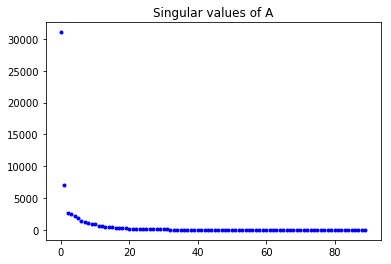

In [10]:
k = 10 # target rank
print("target rank:", k)
# Exact low-rank approximation of A
U, S, V = np.linalg.svd(A, full_matrices=False)
# Uk = U[:, :k]
# Sigmak = np.diag(S[:k])
# Vk = V[:k, :]
# Ak = Uk.dot(Sigmak).dot(Vk)
Ak = low_rank_approx(A, k)
print("Best rank-k approximation error:", np.linalg.norm(A - Ak, ord=2))
plt.plot(np.arange(len(S)), S, 'b.')
# plt.yscale("log")
plt.title("Singular values of A")
# plt.xticks(np.arange(len(S)))
plt.show()

In [11]:
# AA = SA.T
# print("AA:", AA.shape)
# BB = A.T
# print("BB:", BB.shape)
# XX = np.linalg.lstsq(AA, BB, rcond=None)[0]
# print("XX", XX.shape)
# print("||AA*XX - BB||:", np.linalg.norm(AA.dot(XX) - BB))
# print("||BB||:", np.linalg.norm(BB))
# XX_approx = approx_embedding(SA, A)
# print("||AA*XX_approx - BB||:", np.linalg.norm(XX_approx.dot(SA) - A))

In [12]:
# size of input data matrix A
# n = 200
# d = 100
# k = 10
# A = input_mat(n, d, k)

n, d = A.shape
print("size of input matrix A:", n, d)

# Step 1: sample 10% rows and construct m*n CountSketch matrix
m = n // 10
# m = 1000
S_size, S_h, S_sigma = count_sketch(m, n)
print("size of CountSketch matrix S:", S_size)

# Step 2: compute SA
SA = count_sketch_multi(S_size, S_h, S_sigma, A)
print("size of SA:", SA.shape)

# Step 3: project each of the rows onto SA
X1 = approx_embedding(SA, A)
X2 = exact_embedding(SA, A) # for comparison purpose
print("||X - X_1|| (error norm of projection onto SA):", np.linalg.norm(X1 - X2, ord=2)) # X2 should be close to X1

print("||A - X_1 * SA||:", np.linalg.norm(A - X1.dot(SA), ord=2))

# DELETE:
# X1 = X2

# # Step 4: find the best rank-k approximation of projected points inside of rowspace SA
# X_approx = low_rank_approx(X1, k)
# print("||X_approx|| (norm of projection matrix):", np.linalg.norm(X1, ord=2))
# print("approximation error on projection matrix:", np.linalg.norm(X1 - X_approx, ord=2))
# print("Best approximation error on projection matrix:", np.linalg.norm(X1 - low_rank_approx(X1, k),
#                                                                        ord=2))
X_approx = X1

# Verify that A is closely approximated by the product of X_approx and SA
print('||A - X_approx * (SA)|| (Low rank approximation error):', np.linalg.norm(A - X_approx.dot(SA), ord=2))
print('||A - X_precise * (SA)|| (Low rank approximation with exact projection):',
      np.linalg.norm(A - X2.dot(SA), ord=2))
print('||A - A_k|| (Best rank-k approximation error):', np.linalg.norm(A - low_rank_approx(A, k),
                                                           ord=2))
print('||A - A_m|| (Best rank-m approximation error):',
      np.linalg.norm(A - low_rank_approx(A, m), ord=2))
print('size of A:', A.shape)
print('size of X_approx', X_approx.shape, ' | size of SA:', SA.shape)

size of input matrix A: 399 90
size of CountSketch matrix S: [39, 399]
size of SA: (39, 90)
||X - X_1|| (error norm of projection onto SA): 33.1399079551003
||A - X_1 * SA||: 2434.395717458707
||A - X_approx * (SA)|| (Low rank approximation error): 2434.395717458707
||A - X_precise * (SA)|| (Low rank approximation with exact projection): 102.71841995400037
||A - A_k|| (Best rank-k approximation error): 863.8968140028624
||A - A_m|| (Best rank-m approximation error): 24.046269581147964
size of A: (399, 90)
size of X_approx (399, 39)  | size of SA: (39, 90)


In [13]:
U, S, V = np.linalg.svd(SA, full_matrices=False)
S

array([3.37471182e+04, 8.17227800e+03, 3.32788586e+03, 2.58502773e+03,
       1.76740089e+03, 1.63556079e+03, 1.31550061e+03, 1.04508845e+03,
       9.03802866e+02, 8.42713276e+02, 6.77134538e+02, 5.72112643e+02,
       4.57595479e+02, 4.34471648e+02, 3.18720526e+02, 2.95733544e+02,
       2.61484389e+02, 2.36117092e+02, 1.99084036e+02, 1.83809100e+02,
       1.49361206e+02, 1.17033872e+02, 1.14884182e+02, 9.97283178e+01,
       9.30976765e+01, 8.24945200e+01, 6.67621791e+01, 5.36388991e+01,
       5.11614472e+01, 3.73004889e+01, 3.57000649e+01, 3.09439568e+01,
       2.42610654e+01, 2.16222055e+01, 1.48020465e+01, 9.73746844e+00,
       8.08717293e+00, 7.33388438e+00, 4.36876416e+00])

# Part III: Test on high-resolution images
Let's try to compress the following image
<img src="Data/Images/SpaceWalk_2.jpg" width="400">

In [15]:
from PIL import Image
img = Image.open("Data/Images/SpaceWalk_2.jpg")
img = np.array(img)
print("Size of image:", img.shape)

Size of image: (1041, 1041, 3)


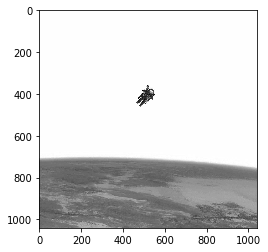

In [16]:
plt.imshow(img[:, :, 0], cmap=matplotlib.cm.binary)

In [21]:
def lra_countsketch(A, k, m=None):
    """
    Perform low rank approximation via CountSketch sampling.
    
    A: input matrix
    k: target rank
    m: sample size (if None, m is 10% of number of rows in A)
    
    Output:
    G, H: A is approximated by G*H
    """
    n, d = A.shape
    print("size of input matrix A:", n, d)

    # Step 1: sample 10% rows and construct m*n CountSketch matrix
    if m is None:
        m = n // 10
    # m = 1000
    S_size, S_h, S_sigma = count_sketch(m, n)
    print("size of CountSketch matrix S:", S_size)

    # Step 2: compute SA
    SA = count_sketch_multi(S_size, S_h, S_sigma, A)
    print("size of SA:", SA.shape)

    # Step 3: project each of the rows onto SA
    X1 = approx_embedding(SA, A)
    X2 = exact_embedding(SA, A) # for comparison purpose
    print("||X - X_1|| (error norm of projection onto SA):", np.linalg.norm(X1 - X2, ord=2)) # X2 should be close to X1

    print("||A - X_1 * SA||:", np.linalg.norm(A - X1.dot(SA), ord=2))

    # DELETE:
    # X1 = X2

    # # Step 4: find the best rank-k approximation of projected points inside of rowspace SA
    # X_approx = low_rank_approx(X1, k)
    # print("||X_approx|| (norm of projection matrix):", np.linalg.norm(X1, ord=2))
    # print("approximation error on projection matrix:", np.linalg.norm(X1 - X_approx, ord=2))
    # print("Best approximation error on projection matrix:", np.linalg.norm(X1 - low_rank_approx(X1, k),
    #                                                                        ord=2))
    X_approx = X1
    
    # Verify that A is closely approximated by the product of X_approx and SA
    print('Low rank approximation error:', np.linalg.norm(A - X_approx.dot(SA), ord=2))
    print('Best low rank approximation error:', np.linalg.norm(A - low_rank_approx(A, k),
                                                               ord=2))
    print('size of A:', A.shape)
    print('size of G', X_approx.shape, ' | size of H:', SA.shape)
    return X_approx, SA

In [22]:
k = 10
A = img[:, :, 0]
G, H = lra_countsketch(A, k)

size of input matrix A: 1041 1041
size of CountSketch matrix S: [104, 1041]
size of SA: (104, 1041)
||X - X_1|| (error norm of projection onto SA): 10627.128545010142
||A - X_1 * SA||: 2416266.935153995
Low rank approximation error: 2416266.935153995
Best low rank approximation error: 1852.1867268008134
size of A: (1041, 1041)
size of G (1041, 104)  | size of H: (104, 1041)


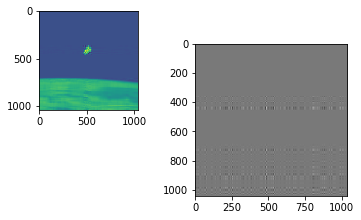

In [28]:
plt.figure(figsize=(20, 20))
fig = plt.subplot(221)
fig.imshow(A, cmap=matplotlib.cm.binary)
fig.set_title("Original Image")
fig = plt.subplot(222)
fig.imshow(G.dot(H), cmap=matplotlib.cm.binary)
fig.set_title("Low Rank Approximation")
fig = plt.subplot(223)
fig.imshow(low_rank_approx(A, k))
fig.set_title("Best Rank k Approximation")
fig = plt.subplot(224)
fig.imshow

### Related Problems
- **Column subset selection (feature selection, CX, CUR)**: $\Pi$ consists of columns of $M$. ([Friez-Kannan-Vempala 98], [Drineas-Mahoney-Muthukrishnan 06], [Deshpande-Vempala 06])

### Online Algorithms

- Columns arrive one by one
- Need to add to $S$ or ignore
- Complete with best $S$ in hindsight (in approximation error)

**Online PCA:** [Boutsidis-Garber-Karnin-Liberty 15] additive approximation $\epsilon\|U\|_F^2$ using $k\cdot polylog(n)$ dimensions.

**Online CUR:** [Bhaskara 18] $(1+\epsilon)$ relative error using $k\cdot polylog(n/\epsilon)$ columns using adaptive sampling, if a) we have a $poly(n)$ approximation of OPT, and $\sigma^2_{max}/OPT$ is at most $poly(n, d)$.

**Online k-means:** [Meyerson 01] objective: small number of clusters, near-optimal centers

### Constructing sampling distribution

**Assumptions (not essential):**
- OPT ($=\|U - U_k\|_F$) is known 
- $\|U\|_2$ is known

**"Ideal" algorithm:**
- Select a column with probability proportional to how much it can reduce the objective function:
$$
p_i := Pr(u_i\rightarrow S) = \min\{1, k\cdot\frac{\|\Pi_S^\perp u_i\|_2^2}{OPT}\}
$$
- Difficult to analyze
- Observation: it is impossible to have many $p_i$ to be close to 1 (it means $u_i$ has a large component perpendicular to previous chosen columns). Otherwise $U$ is not numerial low rank (Geometric lemma).